In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from openaq import OpenAQ
from datetime import datetime
from prophet import Prophet
import folium
import time
import os
from dotenv import load_dotenv

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
#loading health data
health_data = pd.read_csv("Cases_data.csv")

In [4]:
#loading airquality data
load_dotenv(dotenv_path=".gitignore/.env")  # this loads .env file

API_KEY = os.getenv("API_KEY")

headers = {
    "X-API-Key": API_KEY
}
headers = {
    'accept': 'application/json',
    'X-API-KEY': os.getenv("API_KEY")
}

params = {
    'date_to': '2023-12-31T23:59:59Z',
    'date_from': '2021-01-01T00:00:00Z',
    'limit': 1000,
    'page': 1,
}


# To store all results
all_data = []

while True:
    response = requests.get('https://api.openaq.org/v3/sensors/23534/days/monthly', params=params, headers=headers)

    if response.status_code != 200:
        print("Error:", response.status_code, response.text)
        break

    data = response.json()
    results = data.get("results", [])

    if not results:
        break

    all_data.extend(results)
    print(f"Fetched page {params['page']}, total records: {len(all_data)}")

    # Check if there is a next page
    meta = data.get("meta", {})
    if not meta.get("found") or (params['page'] * params['limit'] >= meta.get("found", 0)):
        break

    params["page"] += 1

# Convert to DataFrame
df = pd.DataFrame(all_data)

# Show a sample
print(df.head())

# Save to CSV
df.to_csv("delhi_pm25_2021_2023.csv", index=False)
print(f"Saved {len(df)} records to delhi_pm25_2021_2023.csv")

#data_cleaning
df['date_from'] = df['period'].apply(
    lambda d: pd.to_datetime(d['datetimeFrom']['local']).strftime("%d-%m-%y")
)
df['date_to'] = df['period'].apply(
    lambda d: pd.to_datetime(d['datetimeTo']['local']).strftime("%d-%m-%y")
)

airQuality_data = pd.read_csv("delhi_pm25_2021_2023.csv")

Fetched page 1, total records: 36
   value             flagInfo  \
0  211.0  {'hasFlags': False}   
1  154.0  {'hasFlags': False}   
2   88.6  {'hasFlags': False}   
3   72.6  {'hasFlags': False}   
4   48.7  {'hasFlags': False}   

                                           parameter  \
0  {'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'd...   
1  {'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'd...   
2  {'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'd...   
3  {'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'd...   
4  {'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'd...   

                                              period coordinates  \
0  {'label': '1 month', 'interval': '1 month', 'd...        None   
1  {'label': '1 month', 'interval': '1 month', 'd...        None   
2  {'label': '1 month', 'interval': '1 month', 'd...        None   
3  {'label': '1 month', 'interval': '1 month', 'd...        None   
4  {'label': '1 month', 'interval': '1 month', 'd...        None   

                     

In [5]:
#data_cleaning of delhi_pm25 file
df['date'] = df['period'].apply(
    lambda d: pd.to_datetime(d['datetimeFrom']['local']).strftime("%d-%m-%y")
)
df['date_to'] = df['period'].apply(
    lambda d: pd.to_datetime(d['datetimeTo']['local']).strftime("%d-%m-%y")
)
df.to_csv("delhi_pm25_2021_2023.csv", index=False)
airQuality_data = pd.read_csv("delhi_pm25_2021_2023.csv")

In [6]:
airQuality_data['parameter'].head()

0    {'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'd...
1    {'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'd...
2    {'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'd...
3    {'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'd...
4    {'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'd...
Name: parameter, dtype: object

In [7]:
#data cleaning of cases data
df = pd.read_csv("Cases_data.csv")

df["date"] = pd.to_datetime(
    df["Month"].astype(str) + " " + df["Year"].astype(str) + " 01",
    format="%B %Y %d",   # Use %b instead of %B if months are in short form (Jan, Feb)
    errors="coerce"      # In case there are invalid values
)

# Convert to dd-mm-yy
df["date"] = df["date"].dt.strftime("%d-%m-%y")
df.to_csv("Cases_data.csv", index=False)
print(df["date"])

0     01-01-21
1     01-02-21
2     01-03-21
3     01-04-21
4     01-05-21
5     01-06-21
6     01-07-21
7     01-08-21
8     01-09-21
9     01-10-21
10    01-11-21
11    01-12-21
12    01-01-22
13    01-02-22
14    01-03-22
15    01-04-22
16    01-05-22
17    01-06-22
18    01-07-22
19    01-08-22
20    01-09-22
21    01-10-22
22    01-11-22
23    01-12-22
24    01-01-23
25    01-02-23
26    01-03-23
27    01-04-23
28    01-05-23
29    01-06-23
30    01-07-23
31    01-08-23
32    01-09-23
33    01-10-23
34    01-11-23
Name: date, dtype: object


In [8]:
df = pd.merge(airQuality_data, health_data, on='date', how='inner')
df.head()

,value,flagInfo,parameter,period,coordinates,summary,coverage,date_from,date_to,date,Sl. No.,Year,Month,Average AQI,Total Number of Respiratory illness cases reported to Emergency Department
0,211.0,{'hasFlags': False},"{'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'd...","{'label': '1 month', 'interval': '1 month', 'd...",NaN,"{'min': 70.79166412353516, 'q02': 80.566667175...","{'expectedCount': 31, 'expectedInterval': '744...",01-01-21,01-02-21,01-01-21,1,2021,January,324,3276
1,154.0,{'hasFlags': False},"{'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'd...","{'label': '1 month', 'interval': '1 month', 'd...",NaN,"{'min': 47.71428680419922, 'q02': 51.357143402...","{'expectedCount': 28, 'expectedInterval': '672...",01-02-21,01-03-21,01-02-21,2,2021,February,287,3367
2,88.6,{'hasFlags': False},"{'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'd...","{'label': '1 month', 'interval': '1 month', 'd...",NaN,"{'min': 46.78260803222656, 'q02': 54.913042449...","{'expectedCount': 31, 'expectedInterval': '744...",01-03-21,01-04-21,01-03-21,3,2021,March,223,3747
3,72.6,{'hasFlags': False},"{'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'd...","{'label': '1 month', 'interval': '1 month', 'd...",NaN,"{'min': 32.11111068725586, 'q02': 33.333610916...","{'expectedCount': 30, 'expectedInterval': '720...",01-04-21,01-05-21,01-04-21,4,2021,April,201,3270
4,48.7,{'hasFlags': False},"{'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'd...","{'label': '1 month', 'interval': '1 month', 'd...",NaN,"{'min': 18.714284896850586, 'q02': 18.82761833...","{'expectedCount': 31, 'expectedInterval': '744...",01-05-21,01-06-21,01-05-21,5,2021,May,144,1917


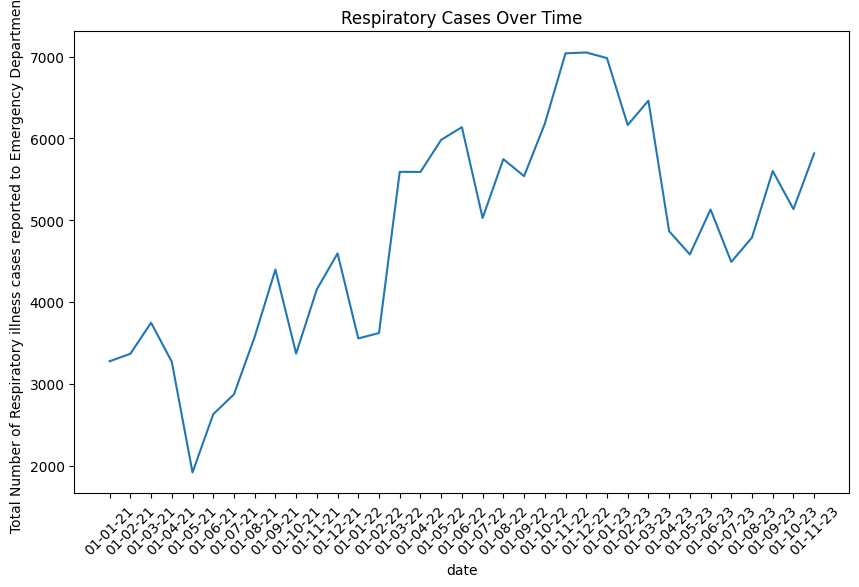

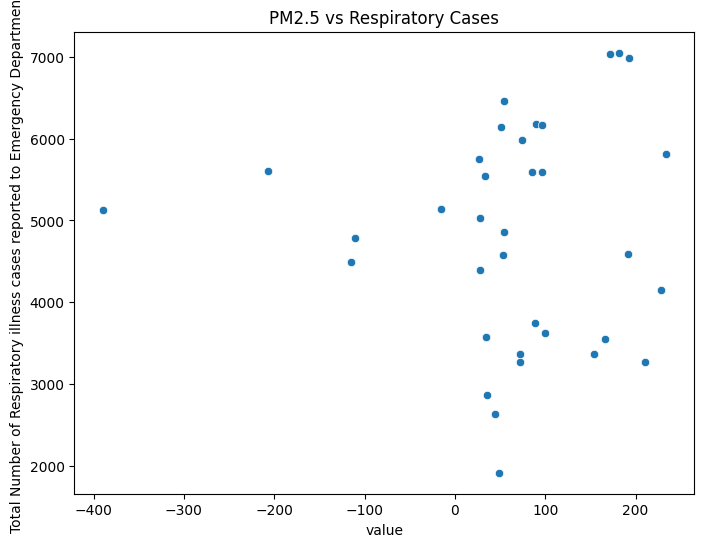

In [15]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="date", y="Total Number of Respiratory illness cases reported to Emergency Department")
plt.title("Respiratory Cases Over Time")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="value", y="Total Number of Respiratory illness cases reported to Emergency Department")
plt.title("PM2.5 vs Respiratory Cases")
plt.show()


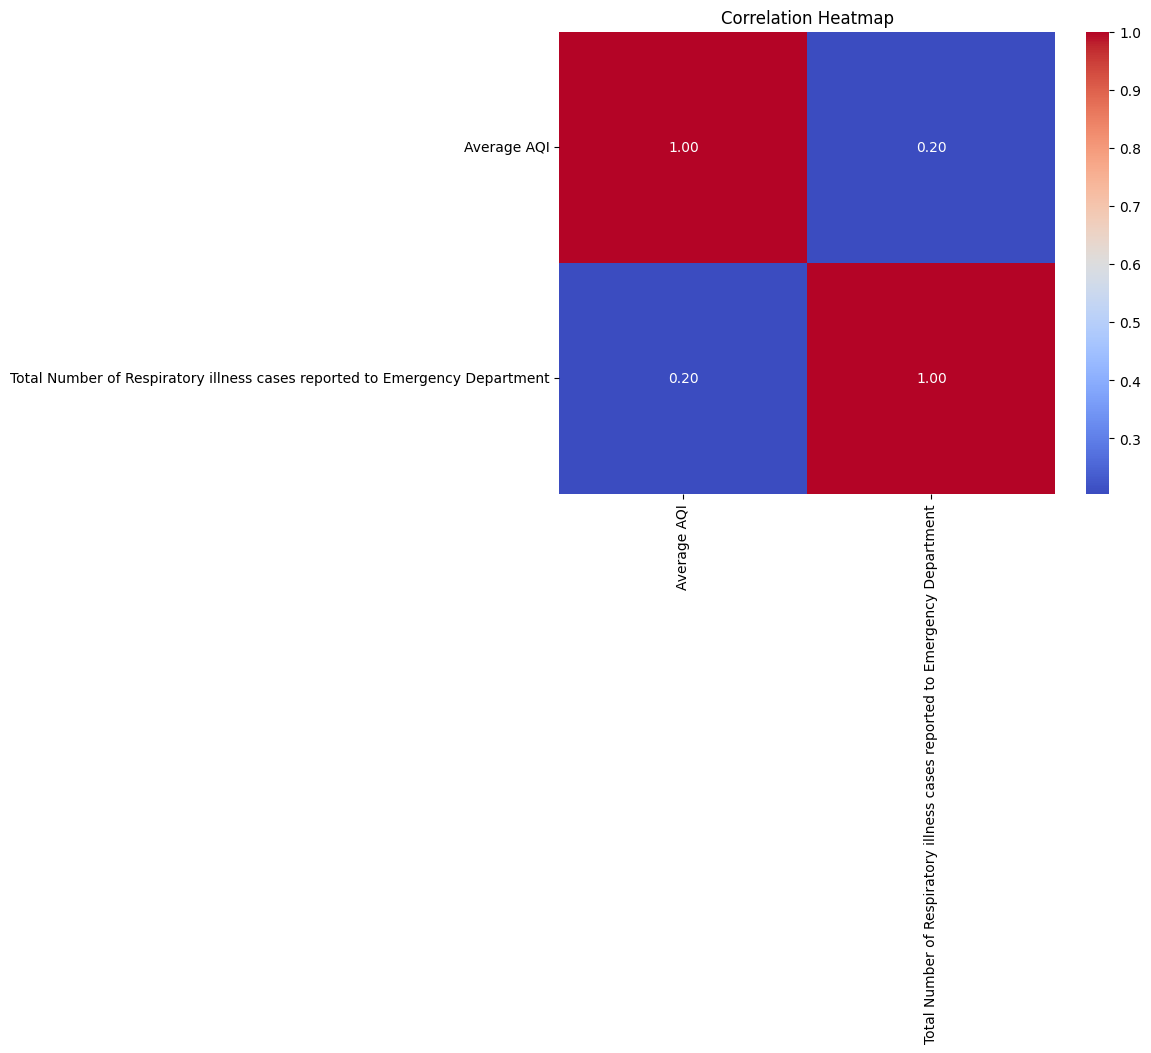

In [18]:
corr = df[["Average AQI", "Total Number of Respiratory illness cases reported to Emergency Department"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
corr = df['value'].corr(df['Total Number of Respiratory illness cases reported to Emergency Department'])
print(f"Correlation between PM2.5 and cases: {corr}")

Correlation between PM2.5 and cases: 0.02681246413682516


c:\Python312\Lib\site-packages\prophet\forecaster.py:1136: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.history_dates = pd.to_datetime(pd.Series(df['ds'].unique(), name='ds')).sort_values()
c:\Python312\Lib\site-packages\prophet\forecaster.py:290: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
14:22:10 - cmdstanpy - INFO - Chain [1] start processing
14:22:11 - cmdstanpy - INFO - Chain [1] done processing


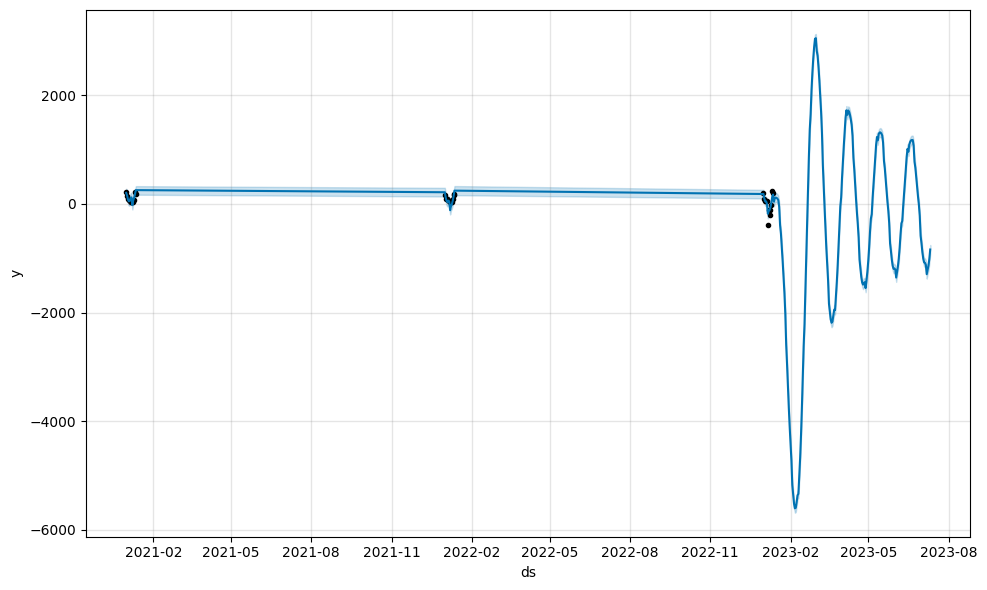

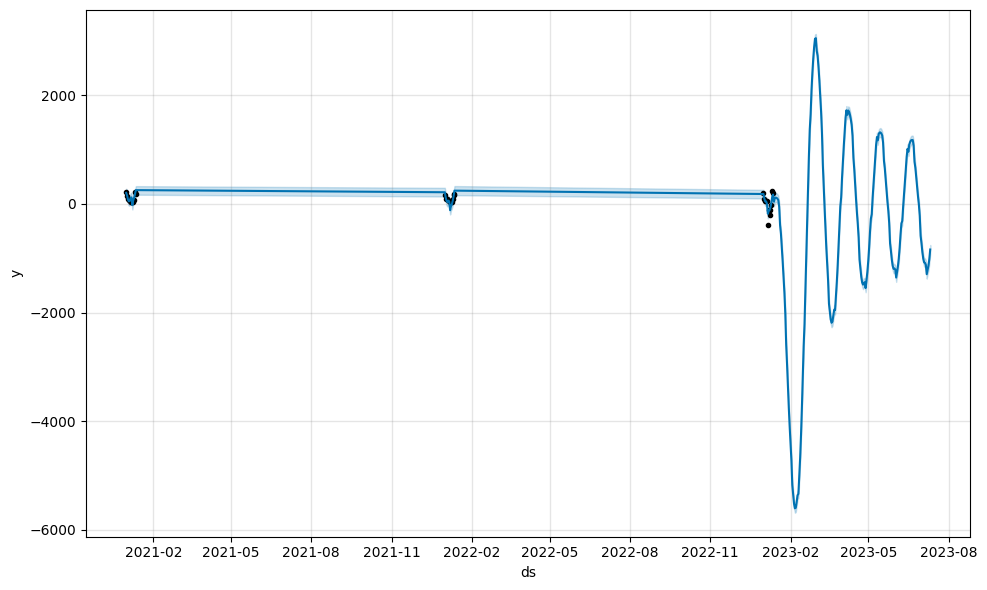

In [ ]:
forecast_df = airQuality_data[['date', 'value']].rename(columns={'date':'ds', 'value':'y'})
model = Prophet()
model.fit(forecast_df)
future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)
model.plot(forecast)

In [ ]:
m = folium.Map(location=[28.61, 77.20], zoom_start=5)
# Add markers based on avg pollution
folium.CircleMarker(location=[28.61, 77.20], radius=8, color='red', fill=True).add_to(m)
m.save("pollution_map.html")